In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd

# Научное программирование $-$ RNN, LSTM, GRU

### Рекуррентная нейронная сеть - Recurrent Neural Network (RNN), 1986-1990

Для обработки последовательностей больше всего подходят рекуррентные нейронные сети.  
Рассмотрим входные данные для такого вида сети:
* $x$ -- последовательность из $N$ элементов (векторов длины $M$);
* $x^{<t>}$ -- элемент последовательности с порядковым номером $t$.

В общем случае, для каждого элемента последовательности делается предсказание $y^{<t>}$. Однако, бывает, что для последовательности требуется сделать одно предсказание, либо некоторое количество, не соответствующее количеству входов.  
Это зависит от набора данных и задачи.

Рассмотрим базовую архитектуру рекуррентной нейронной сети.   

![Базовая рекурректная нейронная сеть](images/simplernn.png)

Формулы, по которым производится расчет значений $h^{<t>}$ и $y^{<t>}$ в базовой рекуррентной сети:

$\Large h^{<t>} = g_1(W_{hh}h^{<t-1>} + W_{hx} x^{<t>} + b_{hx} + b_{hh})$

$y^{<t>} = g_2(W_{yh}h^{<t>} + b_y)$

Где $W_{hh}$, $W_{hx}$, $b_{hx}$, $b_{hh}$, $W_{yh}$, $b_y$ -- веса сети, а $g_1, g_2$ - выбранные функции активации (напр. tanh или softmax).

Основное отличие от остальных видов нейронных сетей - специальная скрытая переменная $h$.  
Эта переменная отвечает за "состояние" ячейки сети в какой-либо момент времени $t$. Ее значение зависит от предыдущих обработанных элементов последовательности.  

За счет наличия скрытой переменной такой тип сетей обладает полезной особенностью: сеть обучается учитывать информацию, которая содержится в последовательностях.  
Такие сети особенно полезны для обработки естественных языков, распознавания речи, распознавания текстов.

## Алгоритм обратного распространения ошибки для реккурентных сетей 
Обратное распространение сквозь время - Backpropagation through the time (BPTT)   
Функция потерь для рекуррентной сети - усредненная сумма всех выходов для последовательности:
$$L(y,\hat{y}) = \frac{1}{T}\sum_{t = 1}^{T}{L(y^{<t>}, \hat{y}^{<t>})}$$ где $T$ - длина последовательности

Развернем схему, показанную ранее:

![Базовая рекурректная нейронная сеть](images/rnn-plain.png)

In [12]:
grad_t_h_rnn = []
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=True)
        self.h2o = nn.Linear(hidden_size, output_size, bias=True)
        
        self.g1 = nn.Tanh()
        #self.g2 = nn.Tanh()
        
    
    def forward(self, x, h):
        h_t = self.g1(self.x2h(x) + self.h2h(h))
        #Данный hook нужен для фиксации градиентов для скрытых состояний.
        #По-другому их вытащить не получилось.
        h_t.register_hook(lambda grad : grad_t_h_rnn.append(grad.detach().clone()))
        o_t = self.h2o(h_t)

        return h_t, o_t


Чтоб было перед глазами повторим:   
$h^{<t>} = g_1(W_{hh}h^{<t-1>} + W_{hx} x^{<t>} + b_{hx} + b_{hh})$

$y^{<t>} = g_2(W_{yh}h^{<t>} + b_y)$

Переобозначим:   
$a^{<t>} = W_{hh}h^{<t-1>} + W_{hx} x^{<t>} + b_{hx} + b_{hh}$   
$h^{<t>} = g_1(a^{<t>})$   
$o^{<t>} = W_{yh}h^{<t>} + b_y$    
$y^{<t>} = g_2(o^{<t>})$

Выведем рекурретные формулы для градиентов весов $W_{yh}, W_{hh}, W_{hx}$

$\Large\frac{\partial L}{\partial W_{yh}} = \sum\frac{\partial L^{<t>}}{\partial W_{yh}}$   
$\Large\frac{\partial L^{<t>}}{\partial W_{yh}} = \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}\frac{\partial o^{<t>}}{\partial W_{yh}} = \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}h^{<t>}$

$\Large\frac{\partial L^{<t>}}{\partial W_{hx}} =  \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}\frac{\partial o^{<t>}}{\partial h^{<t>}}\frac{\partial h^{<t>}}{\partial W_{hx}}$

$\Large\frac{\partial L}{\partial W_{hh}} = \sum\frac{\partial L^{<t>}}{\partial W_{hh}}$

$\Large\frac{\partial L^{<t>}}{\partial W_{hh}} = \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}\frac{\partial o^{<t>}}{\partial W_{hh}} = \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}\frac{\partial o^{<t>}}{\partial h^{<t>}}\frac{\partial h^{<t>}}{\partial W_{hh}} = \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}\frac{\partial o^{<t>}}{\partial h^{<t>}}\frac{\partial h^{<t>}}{\partial g_1}\frac{\partial g_1}{\partial W_{hh}} = \frac{\partial L^{<t>}}{\partial g_2}\frac{\partial g_2}{\partial o^{<t>}}\frac{\partial o^{<t>}}{\partial h^{<t>}}\frac{\partial h^{<t>}}{\partial g_1}\frac{\partial g_1}{\partial a^{<t>}}\frac{\partial a^{<t>}}{\partial W_{hh}}$   

$\Large\frac{\partial a^{<t>}}{\partial W_{hh}} = h^{<t-1>} + \frac{\partial h^{<t-1>}}{\partial W_{hh}} = h^{<t-1>} + \frac{\partial h^{<t-1>}}{\partial g_1}\frac{\partial g_1}{\partial a^{<t-1>}}\frac{\partial a^{<t-1>}}{\partial W_{hh}}$

Рассмотрим производную функции потерь относительно первого скрытого состояния последовательности (не начального):    
$\Large\frac{\partial L^{<t>}}{\partial h^{<1>}} = \frac{\partial L^{<t>}}{\partial h^{<t>}}\frac{\partial h^{<t>}}{\partial h^{<1>}} = \frac{\partial L^{<t>}}{\partial h^{<t>}}\frac{\partial h^{<t>}}{\partial h^{<t-1>}}\frac{\partial h^{<t-1>}}{\partial h^{<1>}} = \frac{\partial L^{<t>}}{\partial h^{<t>}}\prod\limits_{i = 1}^{t - 1}{\frac{\partial h^{<i+1>}}{\partial h^{<i>}}}$    

Потенциальные проблемы с градиентом для $W_{hh}$ из-за рекуррентности:
* Угасание градиента
* Взрыв градиента

#### Тренировочный набор данных:  
Набор значений $y = sin(x), x \in [0, 4\pi]$   
#### Задача:   
По N предыдущим значениям sin(x) предсказывать следующее за этой последовательностью значение sin(x).

In [3]:
Xmax = 4*np.pi
Xmin = 0
Npoints = 200

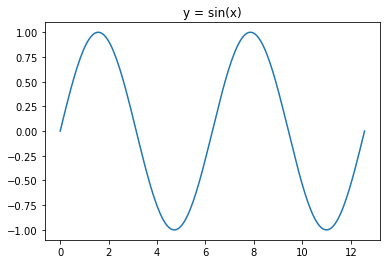

In [4]:
x = np.linspace(Xmin, Xmax, Npoints)
np.random.seed(42)
y_true = np.sin(x)
plt.title('y = sin(x)')
plt.plot(x, y_true)

In [5]:
def create_dataset(x, y, seq_length):
    x_s, y_s = [], []
    for i in range(len(x)-seq_length):
        seq_x = x[i:i+seq_length]
        target_y = y[i+seq_length]
        x_s.append(seq_x)
        y_s.append(target_y)
    return np.array(x_s)[...,None], np.array(y_s)[...,None]

Гиперпараметры:

In [6]:
epochs_num = 100
hidden_size = 1
input_size = 1
output_size = 1

In [7]:
x_data, y_data = create_dataset(y_true, y_true, 4)

In [8]:
x_data.shape, y_data.shape

((196, 4, 1), (196, 1))

In [9]:
print(x_data[0], '\n\n\n' , y_data[0])

[[0.        ]
 [0.06310563]
 [0.12595971]
 [0.18831167]] 


 [0.24991296]


Обучим 4 модели, которые обрабатывают последовательности разной длины: 2, 4, 8, и 16 элементов.

In [10]:
seq_lengths = [2, 4, 8, 16]

In [65]:
global grad_t_h_rnn
losses_rnn = []
stores=[]
grad_t_store_map = {}
hidden_cols = ['epoch', 't', 'seq_length']
hidden_sts = ['hidden_{:d}'.format(x) for x in range(0, hidden_size)]
hidden_cols = hidden_sts + hidden_cols
hidden_store = pd.DataFrame(columns=hidden_cols)
models_rnn = []
total_grads = []

#Для каждой длины последовательности обучим свою модель
for seq_len in seq_lengths:
    #Фиксируем рандом
    np.random.seed(42)
    torch.manual_seed(42)
    model = RNN(input_size, hidden_size, output_size)
    #Инициализируем параметры модели равномерным распределением
    for w in model.parameters():
        torch.nn.init.uniform_(w.data, 0, 1)        
    #Нарежем исходный массив с sin на подпоследовательности требуемой длины
    x_data, y_data = create_dataset(y_true, y_true, seq_len)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    model.train()
    
    cur_loss = []
    with trange(epochs_num) as epoch_bar:
        epoch_grad = []
        for e in epoch_bar:
            total_loss = 0
            #Обучение происходит стохастическим градиентным спуском
            for i in range(0, x_data.shape[0]):
                optimizer.zero_grad()
                #Хранение скрытых состояний организуем в виде массива
                hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, seq_len + 1)]
                
                #Размер батча == 1, в данных нет измерения для батча => добавим через None
                x_s = x_data[i][None, ...]
                y_s = y_data[i][None, ...]
                
                #Проходим по всем элементам последовательности
                for t in range(1, seq_len + 1):
                    x_t = torch.tensor(x_s[:,t - 1], dtype=torch.float32)
                    hidden_storage[t], y_t_pred = model(x_t , hidden_storage[t-1])
                
                y_t = torch.tensor(y_s, dtype=torch.float32)
                l_t = criterion(y_t_pred, y_t)
                l_t.backward()        
                optimizer.step()
                
                total_loss += l_t.detach().item()
            for t in range(0, seq_len):
                single_storage = {}
                single_storage['t'] = t
                single_storage['epoch'] = e
                single_storage['seq_length'] = seq_len
                for idx in range(0, hidden_size):
                    single_storage['hidden_' + str(idx)] = hidden_storage[t][0, idx].detach().squeeze()
                hidden_store = hidden_store.append(single_storage, ignore_index=True)
                
            cur_loss.append(total_loss/ x_data.shape[0])
            epoch_bar.set_postfix({'Loss':total_loss/x_data.shape[0]})
            
    grad_t_store_map[seq_len] = grad_t_h_rnn.copy()
    grad_t_h_rnn = []
    losses_rnn.append(cur_loss)
    models_rnn.append(model)

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s, Loss=0.00144]


#### Градиенты $\frac{\partial L}{\partial h_{t}}, ..., \frac{\partial L}{\partial h_{1}}$

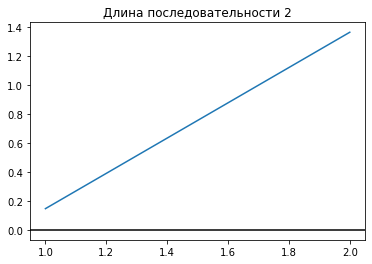

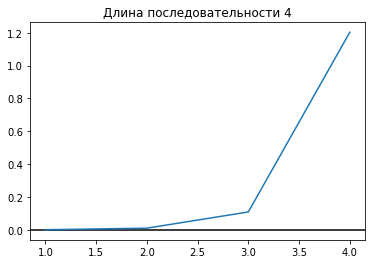

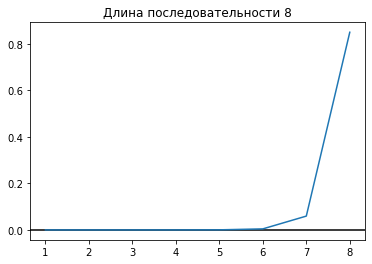

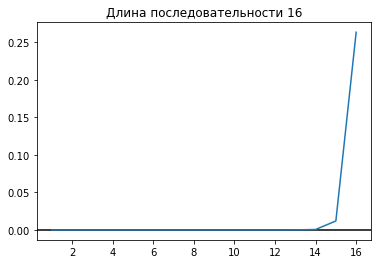

In [66]:
for seq_len in seq_lengths:
    plt.axhline(y=0, color="black")
    plt.plot(range(seq_len, 0, -1), grad_t_store_map[seq_len][0:seq_len])
    
    plt.title('Длина последовательности {:d}'.format(seq_len))
    plt.show()

Наиболее значимый вклад в обучение весов вносит последнее значение, градиент угасает к началу последовательности.

Вид функций, которые выучили части рекуррентной сети:

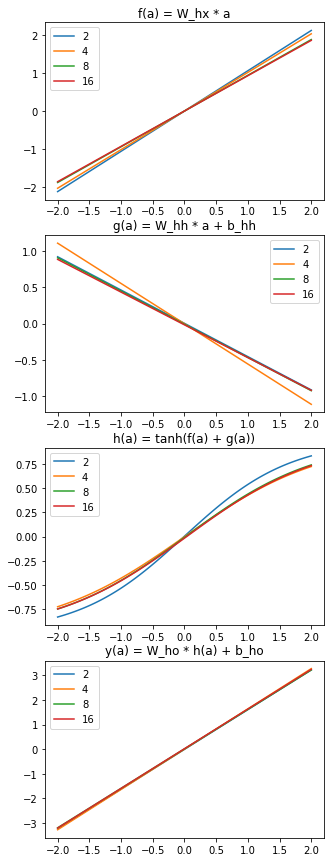

In [67]:
x_plot = np.linspace(-2, 2, 100)
fig, ax = plt.subplots(4,1,figsize=(5,15))
for idx, model in enumerate(models_rnn):
    x2h = model.x2h.weight.data.squeeze().numpy() * x_plot
    ax[0].plot(x_plot, x2h, label=seq_lengths[idx])
    ax[0].set_title('f(a) = W_hx * a')
    ax[0].legend()
    
    h2h =  model.h2h.weight.data.squeeze().numpy() * x_plot +  model.h2h.bias.data.squeeze().numpy()
    ax[1].plot(x_plot, h2h, label=seq_lengths[idx])
    ax[1].set_title('g(a) = W_hh * a + b_hh')
    ax[1].legend()
    ax[2].plot(x_plot, np.tanh(h2h + x2h), label=seq_lengths[idx])
    ax[2].set_title('h(a) = tanh(f(a) + g(a))')
    ax[2].legend()
    h2o =  model.h2o.weight.data.squeeze().numpy() * x_plot +  model.h2o.bias.data.squeeze().numpy()
    ax[3].plot(x_plot, h2o, label=seq_lengths[idx])
    ax[3].set_title('y(a) = W_ho * h(a) + b_ho')
    ax[3].legend()


Поведение функции потерь во время обучения моделей с разными длинами последовательностей:

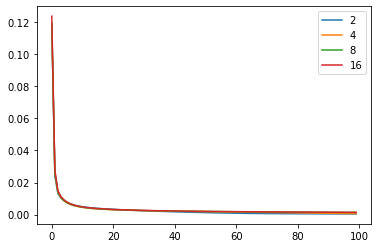

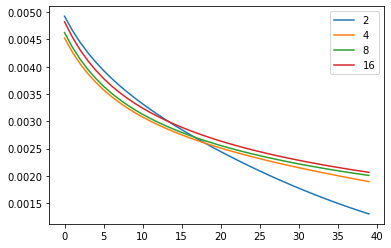

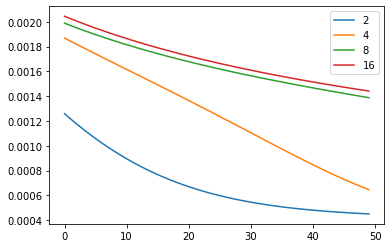

In [68]:
for idx, loss in enumerate(losses_rnn):
    plt.plot(loss, label=seq_lengths[idx])
    plt.legend()
plt.show()
for idx, loss in enumerate(losses_rnn):
    plt.plot(loss[10:50], label=seq_lengths[idx])
    plt.legend()
plt.show()
for idx, loss in enumerate(losses_rnn):
    plt.plot(loss[50:100], label=seq_lengths[idx])
    plt.legend()
plt.show()

Изменение вычисление значений скрытого состояния для последнего элемента в наборе данных, в зависимости от эпохи и длины последовательности:

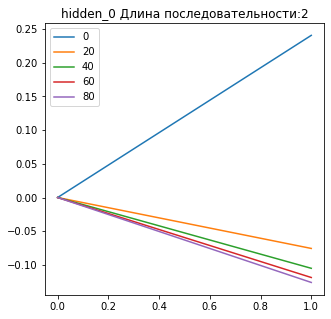

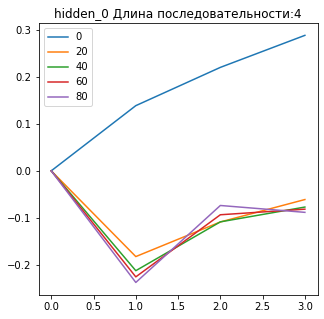

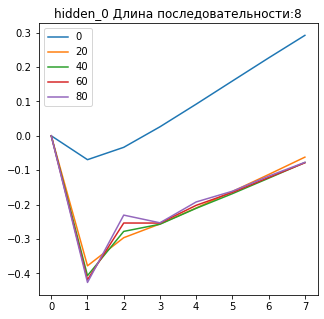

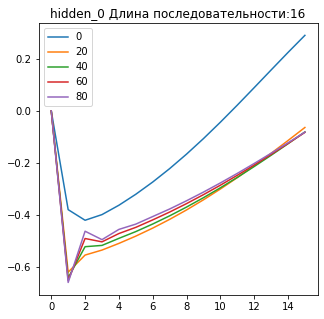

In [69]:
labels = []
period = 20
for seq_len in seq_lengths:
    store_slice = hidden_store[hidden_store['seq_length'] == seq_len]
    fig, ax = plt.subplots(hidden_size, 1, figsize=(5, 5*hidden_size), squeeze=False)
    for e in range(0, store_slice['epoch'].max(), period):
        for idx in range(0, hidden_size):
            ax[idx, 0].plot(store_slice[store_slice['epoch'] == e]['t'], store_slice[store_slice['epoch'] == e]['hidden_{:d}'.format(idx)][:])
            ax[idx, 0].legend(labels=range(0, store_slice['epoch'].max(), period))
            #ax[idx].set_xlabel('T')
            ax[idx, 0].title.set_text('hidden_{:d} Длина последовательности:{:d}'.format(idx, seq_len))
            
    plt.show()

Прогон сети для последовательностей из 4 элементов:

In [70]:
x_data, y_data = create_dataset(y_true, y_true, 4)
x_from_seq = []
y_preds = []
model = models_rnn[1]
model.eval()
hids = []
for idx in range(0, x_data.shape[0]):
    hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    
    x_s = x_data[idx][None, ...]   
  
    for t in range(1, 5):
        x_t = torch.tensor(x_s[:,t-1], dtype=torch.float32)
        hidden_storage[t], y_t_pred = model(x_t , hidden_storage[t-1])
            
    hids.append(hidden_storage[3].squeeze().detach().item())
    y_preds.append(y_t_pred[:].flatten().detach().numpy())

In [71]:
y_preds = np.concatenate(y_preds)
hids = np.array(hids)

Результат:

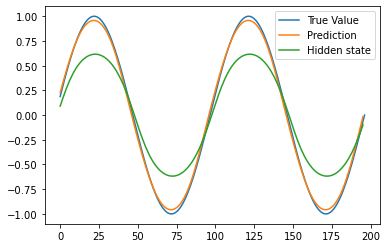

In [72]:
plt.plot(y_true[3:], label='True Value')
plt.plot(y_preds, label='Prediction')
plt.plot(hids, label='Hidden state')
plt.legend()

Для модели, обученной на последовательностях из 4 элементов, рассмотрим связь значения скрытого состояния с подаваемой на вход последовательностью:

In [73]:
x_from_seq = []
model = models_rnn[1]
model.eval()
hids = []
pos = 10 
for idx in range(pos, pos+1):
    hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    
    x_s = x_data[idx][None, ...]  

    for t in range(1, 5):
        x_t = torch.tensor(x_s[:,t-1], dtype=torch.float32)
        hidden_storage[t], y_t_pred = model(x_t , hidden_storage[t-1])
            
    for t in range(1, 5):
        hids.append(hidden_storage[t].squeeze().detach().item())

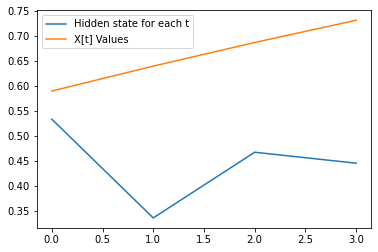

In [74]:
plt.plot(hids, label='Hidden state for each t')
plt.plot(x_data[pos], label='X[t] Values')
plt.legend()

### Долгая краткосрочная память -- LSTM (Long short-term memory), 1997

Из-за размытия градиента в обычных рекуррентных сетях (и потере информации о долгосрочных зависимостях) был разработан специальный вид рекуррентных сетей -- LSTM.  
Скрытое состояние $h^{<t>}$ учитывает только краткосрочные зависимости.
Для учета долгосрочных зависимостей по всей последовательности было добавлено специальное состояние для ячейки -- $c^{<t>}$.

Обновление значений скрытого состояния происходит при помощи специальных структур, называемых фильтрами (Gates).
В следствие этого формулы для обновления состояний усложняются. Появляются дополнительные линейные слои.

![Строение ячейки базовой рекуррентной нейронной сети](images/lstm.png)

Формулы обновления состояний для LSTM:   
$i^{<t>} = \sigma(W_{ix}x^{<t>} + b_{ix} + W_{ih}h^{<t-1>} + b_{ih})$ -- Фильтр входа (Input Gate)    
$f^{<t>} = \sigma(W_{fx}x^{<t>} + b_{fx} + W_{fh}h^{<t-1>} + b_{fh})$ -- Фильтр забывания (Forget Gate)     
$g^{<t>} = tanh(W_{gx}x^{<t>} + b_{gx} + W_{gh}h^{<t-1>} + b_{gh})$ -- Фильтр ячейки (Cell Gate)    
$o^{<t>} = \sigma(W_{ox}x^{<t>} + b_{ox} + W_{oh}h^{<t-1>} + b_{oh})$ -- Фильтр выхода (Output Gate)     
$c^{<t>} = f^{<t>} \odot c^{<t-1>} + i^{<t>} \odot g^{<t>}$ -- обновление ячейки LSTM-слоя    
$h^{<t>} = o^{<t>} \odot tanh(c^{<t>})$ -- обновление скрытого состояния     

In [75]:
grad_t_h_lstm = []
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.forget_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.forget_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.input_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.input_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.cell_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.cell_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.output_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.output_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.hy = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, x, last_hidden, last_cell_state):
        f_t = self.sigmoid(self.forget_gate_x(x) + self.forget_gate_h(last_hidden))
        i_t = self.sigmoid(self.input_gate_x(x) + self.input_gate_h(last_hidden))
        g_t = self.tanh(self.cell_gate_x(x) + self.cell_gate_h(last_hidden))
        o_t = self.sigmoid(self.output_gate_x(x) + self.output_gate_h(last_hidden))
        
        c_t = f_t * last_cell_state + i_t * g_t
        h_t = o_t * self.tanh(c_t)
        h_t.register_hook(lambda grad : grad_t_h_lstm.append(grad.detach().clone()))
        y_t = self.hy(h_t)
        
        return h_t, c_t, y_t
        
        
        

In [77]:
#Данный код аналогичен коду для обычной RNN.
#За исключением того, что LSTM дополнительно требуется
#хранить состояние ячейки.
global grad_t_h_lstm
losses_lstm = []
stores=[]

grad_t_store_map_lstm = {}
models_lstm = []

for seq_len in seq_lengths:
    np.random.seed(42)
    torch.manual_seed(42)
    model = LSTM(input_size, hidden_size, output_size)
    for w in model.parameters():
        torch.nn.init.uniform_(w.data, 0, 1)
    x_data, y_data = create_dataset(y_true, y_true, seq_len)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    model.train()

    hidden_cols = ['epoch', 't']
    hidden_sts = ['hidden_{:d}'.format(x) for x in range(0, hidden_size)]
    hidden_cols = hidden_sts + hidden_cols
    hidden_store = pd.DataFrame(columns=hidden_cols)
    cur_loss = []
    with trange(epochs_num) as epoch_bar:
        for e in epoch_bar:
            total_loss = 0
            for i in range(0, x_data.shape[0]):
                optimizer.zero_grad()
                hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, seq_len + 1)]
                cell_storage = [torch.zeros(1, hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, seq_len + 1)]
                
                x_s = x_data[i][None, ...]
                y_s = y_data[i][None, ...]

                for t in range(1, seq_len + 1):
                    x_t = torch.tensor(x_s[:,t - 1], dtype=torch.float32)
                    hidden_storage[t], cell_storage[t], y_t_pred = model(x_t , hidden_storage[t-1], cell_storage[t-1])

                y_t = torch.tensor(y_s, dtype=torch.float32)
                l_t = criterion(y_t_pred, y_t)
                l_t.backward()
                optimizer.step()
                
                total_loss += l_t.detach().item()
            for t in range(0, seq_len):
                single_storage = {}
                single_storage['t'] = t
                single_storage['epoch'] = e
                for idx in range(0, hidden_size):
                    single_storage['hidden_' + str(idx)] = hidden_storage[t][:, idx].detach().squeeze()
                hidden_store = hidden_store.append(single_storage, ignore_index=True)
                
            cur_loss.append(total_loss/ x.shape[0])
            epoch_bar.set_postfix({'Loss':total_loss/ x.shape[0]})
            
    grad_t_store_map_lstm[seq_len] = grad_t_h_lstm.copy()
    grad_t_h_lstm = []
    losses_lstm.append(cur_loss)
    models_lstm.append(model)

100%|██████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it, Loss=0.00248]


Поведение функции потерь для LSTM:

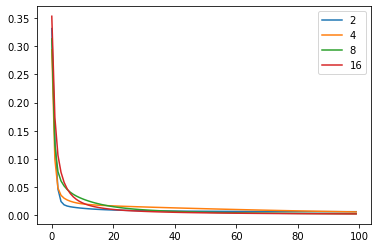

In [79]:
for idx, loss in enumerate(losses_lstm):
    plt.plot(loss, label=seq_lengths[idx])
    plt.legend()
plt.show()

#### Градиенты $\frac{\partial L}{\partial h_{t}}, ..., \frac{\partial L}{\partial h_{1}}$

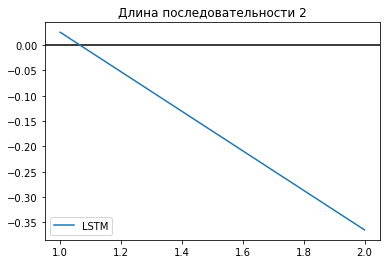

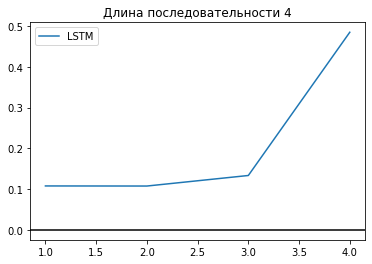

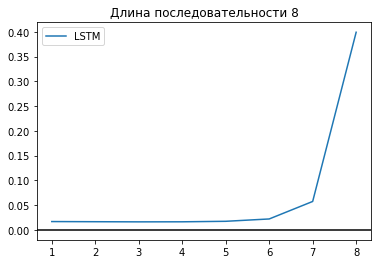

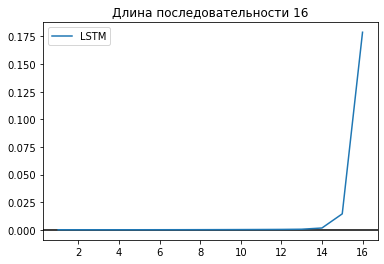

In [80]:
for seq_len in seq_lengths: 
    plt.axhline(y=0, color="black")
    plt.plot(range(seq_len, 0, -1), grad_t_store_map_lstm[seq_len][0:seq_len], label='LSTM')
    plt.title('Длина последовательности {:d}'.format(seq_len))
    plt.legend()
    plt.show()

Сравним градиенты по скрытым состояниям с обычной рекурретной сетью:

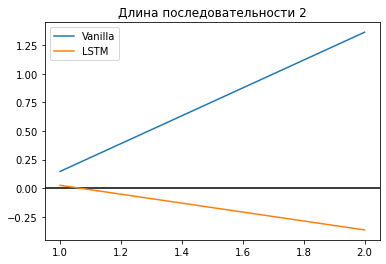

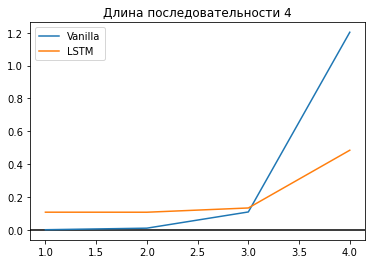

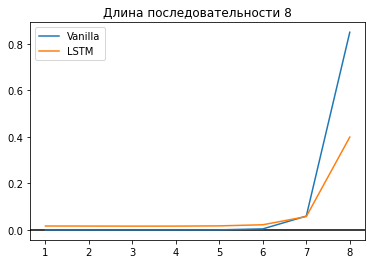

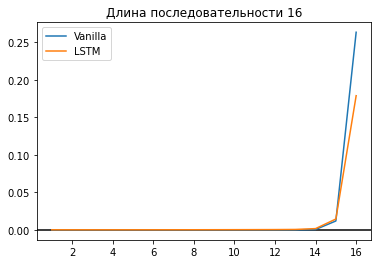

In [81]:
for seq_len in seq_lengths: 
    plt.axhline(y=0, color="black")
    plt.plot(range(seq_len, 0, -1), grad_t_store_map[seq_len][0:seq_len], label='Vanilla')
    plt.plot(range(seq_len, 0, -1), grad_t_store_map_lstm[seq_len][0:seq_len], label='LSTM')
    plt.title('Длина последовательности {:d}'.format(seq_len))
    plt.legend()
    plt.show()

Запуск модели LSTM, обученной для последовательностей из 4 элементов:

In [82]:
x_data, y_data = create_dataset(y_true, y_true, 4)
x_from_seq = []
y_preds = []
model = models_lstm[1]
model.eval()
hids = []
cids = []
for idx in range(0, x_data.shape[0]):
    hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    cell_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    
    x_s = x_data[idx][None, ...]
    x_t = torch.tensor(x_s, dtype=torch.float32)
  
    for t in range(1, 5):
        x_t = torch.tensor(x_s[:,t-1], dtype=torch.float32)
        hidden_storage[t], cell_storage[t], y_t_pred = model(x_t , hidden_storage[t-1], cell_storage[t-1])
            
    hids.append(hidden_storage[3].squeeze().detach().item())
    cids.append(cell_storage[3].squeeze().detach().item())
    y_preds.append(y_t_pred[:].flatten().detach().numpy())

In [83]:
y_preds = np.concatenate(y_preds)
hids = np.array(hids)
cids = np.array(cids)

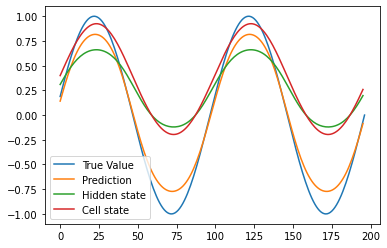

In [84]:
plt.plot(y_true[3:], label='True Value')
plt.plot(y_preds, label='Prediction')
plt.plot(hids, label='Hidden state')
plt.plot(cids, label='Cell state')
plt.legend()

Значения скрытого состояния и состояния ячейки для выбранной последовательности из набора данных:

In [85]:
x_from_seq = []
model = models_lstm[1]
model.eval()
hids = []
cids = []
pos = 10
for idx in range(pos, pos+1):
    hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    cell_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    
    x_s = x_data[idx][None, ...]  
    x_t = torch.tensor(x_s, dtype=torch.float32)
  
    for t in range(1, 5):
        x_t = torch.tensor(x_s[:,t-1], dtype=torch.float32)
        hidden_storage[t], cell_storage[t], y_t_pred = model(x_t , hidden_storage[t-1], cell_storage[t-1])
            
    for t in range(1, 5):
        hids.append(hidden_storage[t].squeeze().detach().item())
        cids.append(cell_storage[t].squeeze().detach().item())

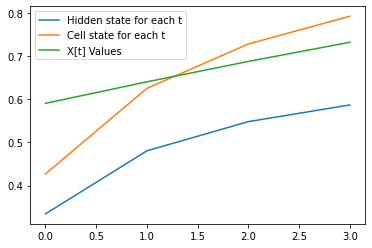

In [86]:
plt.plot(hids, label='Hidden state for each t')
plt.plot(cids, label='Cell state for each t')
plt.plot(x_data[pos], label='X[t] Values')
plt.legend()

### Управляемый рекуррентный блок -- GRU (Gate Relation Unit), 2014

GRU -- упрощенная версия LSTM, содержит меньшее количество фильтров, соответственно, меньшее количество параметров. При этом утверждается, что обобщающая способность такой архитекутры для **некоторых** задач остается сравнимой с LSTM. 

![Строение ячейки базовой рекуррентной нейронной сети](images/gru.png)

Формулы для GRU:

$r^{<t>} = \sigma(W_{rx}x^{<t>} + b_{rx} + W_{rh}h^{<t-1>} + b_{rh})$ -- Фильтр сброса (Reset gate)    
$z^{<t>} = \sigma(W_{zx}x^{<t>} + b_{zx} + W_{zh}h^{<t-1>} + b_{zh})$ -- Фильтр обновления (Update gate)    
$n^{<t>} = tanh(W_{nx}x^{<t>} + b_{nx} + r^{<t>} \odot (W_{nh}h^{<t-1>} + b_{nh}))$ -- Фильтр нового состояния (New gate)  
$h^{<t>} = (1 - z^{<t>}) \odot n^{<t>} + z^{<t>} \odot h^{<t-1>}$ -- Формула скрытого состояния

In [87]:
grad_t_h_gru = []
class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        
        self.reset_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.reset_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.update_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.update_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.new_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.new_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
              
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.hy = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, x, hidden):
        r_t = self.sigmoid(self.reset_gate_x(x) + self.reset_gate_h(hidden))
        z_t = self.sigmoid(self.update_gate_x(x) + self.update_gate_h(hidden))
        n_t = self.tanh(self.new_gate_x(x) + r_t * self.new_gate_h(hidden))
        
        h_t = (1 - z_t) * n_t + z_t * hidden
        h_t.register_hook(lambda grad : grad_t_h_gru.append(grad.detach().clone()))
        y_t = self.hy(h_t)
        
        return h_t, y_t

In [88]:
#Данный код полностью повторяет код обучения обычной RNN.
global grad_t_h_gru
losses_gru = []
stores=[]
models_gru = []
grad_t_store_map_gru= {}
for seq_len in seq_lengths:
    np.random.seed(42)
    torch.manual_seed(42)
    model = GRU(input_size, hidden_size, output_size)
    for w in model.parameters():
        torch.nn.init.uniform_(w.data, 0, 1)
    x_data, y_data = create_dataset(y_true, y_true, seq_len)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    model.train()

    hidden_cols = ['epoch', 't']
    hidden_sts = ['hidden_{:d}'.format(x) for x in range(0, hidden_size)]
    hidden_cols = hidden_sts + hidden_cols
    hidden_store = pd.DataFrame(columns=hidden_cols)
    cur_loss = []
    with trange(epochs_num) as epoch_bar:
        for e in epoch_bar:
            total_loss = 0

            for i in range(0, x_data.shape[0]):
                optimizer.zero_grad()
                hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, seq_len + 1)]
            
                x_s = x_data[i][None, ...]
                y_s = y_data[i][None, ...]

                for t in range(1, seq_len + 1):
                    x_t = torch.tensor(x_s[:,t - 1], dtype=torch.float32)
                    hidden_storage[t], y_t_pred = model(x_t , hidden_storage[t-1])

                y_t = torch.tensor(y_s, dtype=torch.float32)
                l_t = criterion(y_t_pred, y_t)
                l_t.backward()

                hidden_store_row = {}
                total_loss += l_t.detach().item()
                
                optimizer.step()
                
            for t in range(0, seq_len):
                single_storage = {}
                single_storage['t'] = t
                single_storage['epoch'] = e
                for idx in range(0, hidden_size):
                    single_storage['hidden_' + str(idx)] = hidden_storage[t][:, idx].detach().squeeze()
                hidden_store = hidden_store.append(single_storage, ignore_index=True)
                
            cur_loss.append(total_loss/ x_data.shape[0])
            epoch_bar.set_postfix({'Loss':total_loss/ x_data.shape[0]})
            
    grad_t_store_map_gru[seq_len] = grad_t_h_gru.copy()
    grad_t_h_gru = []
    losses_gru.append(cur_loss)
    models_gru.append(model)

100%|██████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it, Loss=0.00261]


Поведение функции потерь для GRU:

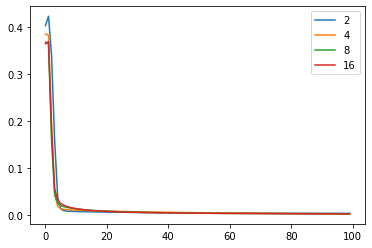

In [89]:
for idx, loss in enumerate(losses_gru):
    plt.plot(loss, label=seq_lengths[idx])
    plt.legend()
plt.show()

Градиенты по скрытым состояниям для GRU:

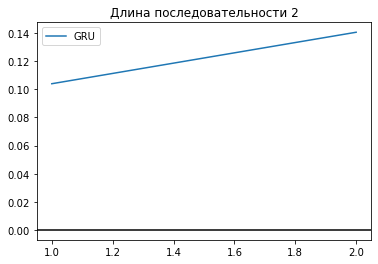

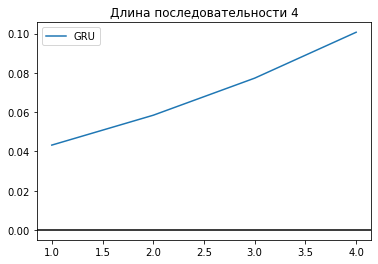

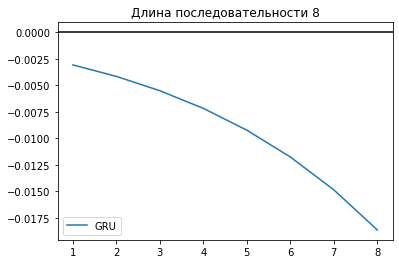

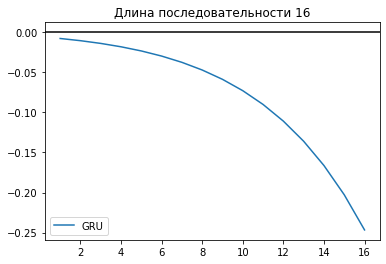

In [90]:
for seq_len in seq_lengths:
    plt.axhline(y=0, color="black")
    plt.plot(range(seq_len, 0, -1), grad_t_store_map_gru[seq_len][0:seq_len], label='GRU')
    plt.title('Длина последовательности {:d}'.format(seq_len))
    plt.legend()
    plt.show()

Градиенты по скрытым состояниям в сравнении с обычной RNN, LSTM:

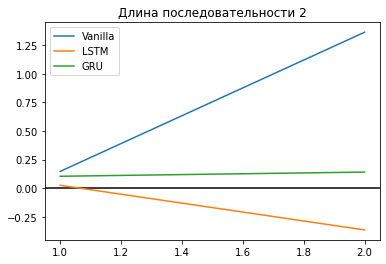

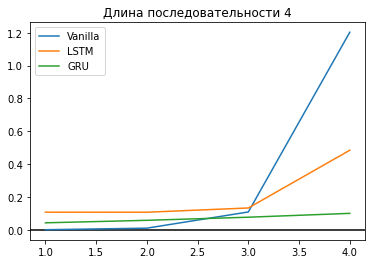

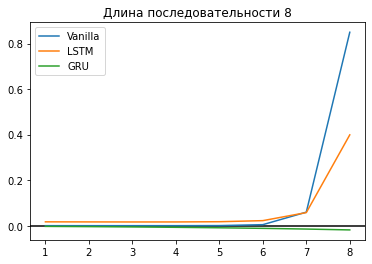

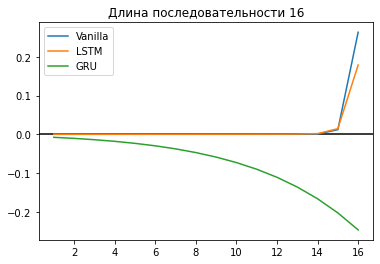

In [91]:
for seq_len in seq_lengths:
    plt.axhline(y=0, color="black")
    plt.plot(range(seq_len, 0, -1), grad_t_store_map[seq_len][0:seq_len], label='Vanilla')
    plt.plot(range(seq_len, 0, -1), grad_t_store_map_lstm[seq_len][0:seq_len], label='LSTM')
    plt.plot(range(seq_len, 0, -1), grad_t_store_map_gru[seq_len][0:seq_len], label='GRU')
    plt.title('Длина последовательности {:d}'.format(seq_len))
    plt.legend()
    plt.show()

Запуск модели GRU, обученной на последовательностях длины 4:

In [92]:
x_data, y_data = create_dataset(y_true, y_true, 4)
x_from_seq = []
y_preds = []
model = models_gru[1]
model.eval()
hids = []
for idx in range(0, x_data.shape[0]):
    hidden_init = torch.zeros(1, hidden_size, dtype=torch.float32)
    hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    
    x_s = x_data[idx][None, ...]
    x_t = torch.tensor(x_s, dtype=torch.float32)

    for t in range(1, 5):
        x_t = torch.tensor(x_s[:,t-1], dtype=torch.float32)
        hidden_storage[t], y_t_pred = model(x_t , hidden_storage[t-1])
    
    hids.append(hidden_storage[3].squeeze().detach().item())
    y_preds.append(y_t_pred[:].flatten().detach().numpy())

In [93]:
y_preds = np.concatenate(y_preds)
hids = np.array(hids)

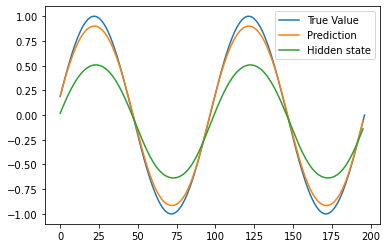

In [94]:
plt.plot(y_true[3:], label='True Value')
plt.plot(y_preds, label='Prediction')
plt.plot(hids, label='Hidden state')
plt.legend()

In [95]:
x_from_seq = []
model = models_gru[1]
model.eval()
hids = []
pos = 10
for idx in range(pos, pos+1):
    hidden_init = torch.zeros(1, hidden_size, dtype=torch.float32)
    hidden_storage = [torch.zeros(1, hidden_size, dtype=torch.float32) for t in range(0, 5)]
    
    x_s = x_data[idx][None, ...]
    x_t = torch.tensor(x_s, dtype=torch.float32)

    for t in range(1, 5):
        x_t = torch.tensor(x_s[:,t-1], dtype=torch.float32)
        hidden_storage[t], y_t_pred = model(x_t , hidden_storage[t-1])
            
    for t in range(1, 5):
        hids.append(hidden_storage[t].squeeze().detach().item())

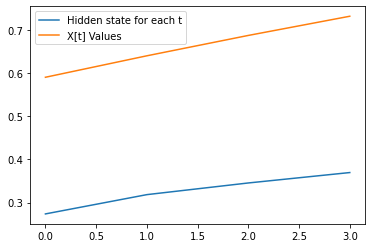

In [96]:
plt.plot(hids, label='Hidden state for each t')
plt.plot(x_data[pos], label='X[t] Values')
plt.legend()

Ссылки на использованные материалы:


[1] [neerc.ifmo.ru - Рекуррентные нейронные сети](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8)      
[2] [d2l.ai - Backpropagation through time](https://d2l.ai/chapter_recurrent-neural-networks/bptt.html)    
[3] [fairyonice.github.io - RNN Sin Prediction Keras](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html)    
[4] [PyTorch - RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)    
[5] [PyTorch - LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)    
[6] [PyTorch - GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

Примечание:    
После лекции я изменил границы равномерного распределения с [0, 1] на [-1, 1] для инициализации весов сетей.
При этом поведение градиентов изменилось. Все сети лучше обучились, но при этом 
эффект угасания градиента проявился для разных архитектур. Это связано с тривиальностью набора 
данных и простотой рассматриваемой задачи для рекуррентной сети.
